# Final Presentation part1

* autogluon hpo + ensemble
* [Ensemble One-shot Nas](https://github.com/aptsunny/Ensemble-One-Shot-NAS)


<kbd>环境配置</kbd> <br />

In [1]:
# Basic utils for folder manipulations etc
import os
import shutil
import time
import re
import multiprocessing # to count the number of CPUs available

# External tools to load and process data
import openml
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# MXNet (NeuralNets)
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon import nn

# AutoGluon and HPO tools
import autogluon as ag

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/optimizer/optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


In [2]:
mx.__version__

'1.6.0'

In [3]:
ag.__version__

'0.0.11'

<kbd>1. 标准训练</kbd> <br />

In [4]:
from autogluon import ImageClassification as task

数据准备
```
    train/
    ├── class1/
        ├── img1.jpg
        ├── ...
    ├── class2/
    ├── ...
```

In [5]:
filename = ag.download('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')
ag.unzip(filename)
dataset = task.Dataset('data/train')

Autogluon fit 函数包括训练以及验证阶段

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.31.37.165/24611/1' processes=1 threads=8, memory=64.28 GB>, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
})



{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd9bc2e5518>, 'net': 'ResNet50_v1b', 'optimizer': <autogluon.core.optimizer.NAG object at 0x7fd9bc2e5550>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 2, 'final_fit_epochs': 2, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 0}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd9bc206b00>, 'net': 'ResNet50_v1b', 'optimizer': <autogluon.core.optimizer.NAG object at 0x7fd9bc206b38>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 2, 'final_fit_epochs': 2, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': True, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 1}


Saving Training Curve in checkpoint/plot_training_curves.png


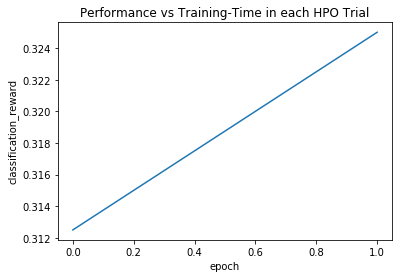

In [6]:
classifier = task.fit(dataset,
                      epochs=2, 
                      num_trials=1,
                      ngpus_per_trial=1,
                      verbose=True)# True # Saving Training Curve

<kbd>记录搜索结果 绘制曲线</kbd> <br />

In [8]:
from matplotlib import pyplot as plt

class draw_efficient_curve:
    def __init__(self, target_hardware):
        self.target_hardware=target_hardware
        self.latency_list= []
        self.top1s = []
        self.legend = []
        self.com = {}
        
    def adj(self, latency_list, top1s):  
        c = []
        d = []
        b=sorted(enumerate(latency_list), key=lambda x:x[1])
        for i in b:
            c.append(i[0])
        for i in c:
            d.append(top1s[i])
        return sorted(latency_list), d

    
    def update_com(self, style, latency, top1, creat_new):
        if creat_new:
            self.com[style]=([], [])
        self.com[style][0].append(latency)
        self.com[style][1].append(top1)
        a,b=self.adj(self.com[style][0], self.com[style][1])
        self.com[style]=(a, b)
        return self.com
    
    def plot(self, style, latency, top1):
        creat_new=False
        if not style in self.legend:
            self.legend.append(style)
            creat_new=True
        self.com= self.update_com(style, latency, top1, creat_new)
        plt.figure(figsize=(4,4))
        for i in range(len(self.legend)):
            if i == 0:  
                plt.plot(self.com[self.legend[i]][0], self.com[self.legend[i]][1], 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label=style)
            elif i == 1:
                # print(self.com[self.legend[i]][0], self.com[self.legend[i]][1])
                plt.plot(self.com[self.legend[i]][0], self.com[self.legend[i]][1], '--', marker='+', linewidth=2, markersize=8, label=style)
            elif i == 2:
                plt.plot(self.com[self.legend[i]][0], self.com[self.legend[i]][1], '--', marker='>', linewidth=2, markersize=8, label=style)
        plt.xlabel('%s Fit Total_time (s)' % self.target_hardware, size=12)
        plt.ylabel('Top-1 Accuracy (%)', size=12)
        # print(style)
        plt.legend(self.legend, loc='lower right')
        plt.grid(True)
        plt.show()
        print('Successfully draw the tradeoff curve!')
        
record = draw_efficient_curve("Telsa V100")

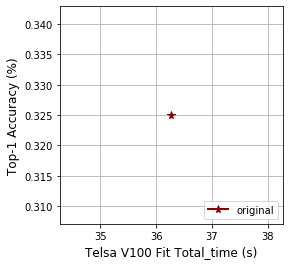

Successfully draw the tradeoff curve!


In [9]:
record.plot('original', classifier.results['total_time'], classifier.results['best_reward'])

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.31.37.165/24611/1' processes=1 threads=8, memory=64.28 GB>, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
})



{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd9a46cb3c8>, 'net': 'ResNet50_v1b', 'optimizer': <autogluon.core.optimizer.NAG object at 0x7fd9a46cb400>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 3, 'final_fit_epochs': 3, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 2}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd9a46bfa58>, 'net': 'ResNet50_v1b', 'optimizer': <autogluon.core.optimizer.NAG object at 0x7fd9a46bfc18>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 3, 'final_fit_epochs': 3, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': True, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 3}


Saving Training Curve in checkpoint/plot_training_curves.png


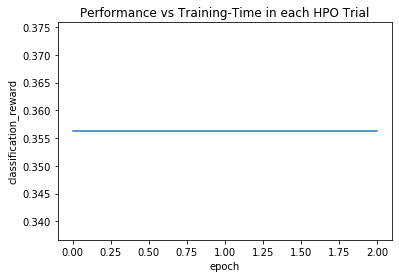

In [10]:
classifier = task.fit(dataset,
                      epochs=3, 
                      num_trials=1,
                      ngpus_per_trial=1,
                      verbose=True)# True # Saving Training Curve

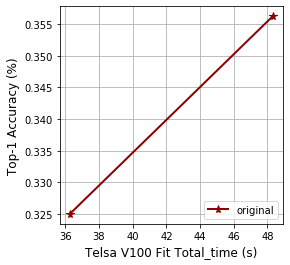

Successfully draw the tradeoff curve!


In [11]:
record.plot('original', classifier.results['total_time'], classifier.results['best_reward'])

In [12]:
classifier.results['search_space']

OrderedDict([('net.choice', Categorical['ResNet50_v1b', 'ResNet18_v1b']),
             ('optimizer.learning_rate', Real: lower=0.001, upper=0.01),
             ('optimizer.wd', Real: lower=0.0001, upper=0.001)])

In [13]:
print('Top-1 val acc: %.3f' % classifier.results['best_reward'])

Top-1 val acc: 0.356


测试集估计结果

In [14]:
test_dataset = task.Dataset('data/test', train=False)
test_acc = classifier.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc)


Top-1 test acc: 0.469


<div class="alert alert-info">
<h4>Note</h4><p> epoch 2/3->10.</p></div>

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 1


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.31.37.165/24611/1' processes=1 threads=8, memory=64.28 GB>, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
})



Saving Training Curve in checkpoint/plot_training_curves.png


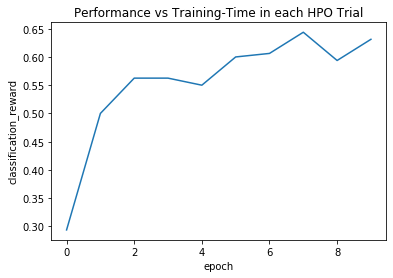

In [15]:
classifier = task.fit(dataset,
                      epochs=10,
                      num_trials=1,
                      ngpus_per_trial=1,
                      verbose=False)

随着训练epoch的增加，查看可否通过有限的资源得到足够满意的结果, 仅仅在trials为1时尝试。

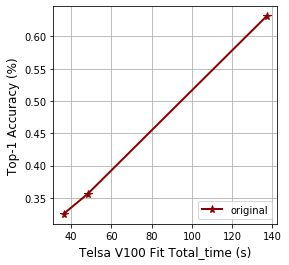

Successfully draw the tradeoff curve!


In [16]:
record.plot('original', classifier.results['total_time'], classifier.results['best_reward'])

<kbd>2. 配置超参搜索空间</kbd> <br />

network

In [17]:
import gluoncv as gcv

@ag.func(
    multiplier=ag.Categorical(0.25, 1.0),
)
def get_mobilenet(multiplier):
    return gcv.model_zoo.MobileNetV2(multiplier=multiplier, classes=4)

net = ag.space.Categorical('resnet50_v1b', get_mobilenet())
print(net)

Categorical['resnet50_v1b', AutoGluonObject]


optimizer

In [18]:
from mxnet import optimizer as optim

@ag.obj(
    multi_precision=True, # False
    learning_rate=ag.space.Real(1e-4, 1e-2, log=True),
    momentum=ag.space.Real(0.85, 0.95),
    wd=ag.space.Real(1e-6, 1e-2, log=True)
)
class NAG(optim.NAG):
    pass

optimizer = NAG()
print(optimizer)

AutoGluonObject -- NAG


Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.31.37.165/24611/1' processes=1 threads=8, memory=64.28 GB>, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
})



Saving Training Curve in checkpoint/plot_training_curves.png


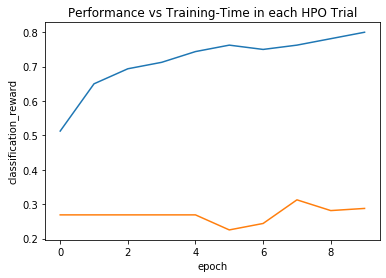

In [19]:
classifier = task.fit(dataset,
                      net=net,
                      lr_scheduler=ag.space.Categorical('poly', 'cosine'),
                      optimizer=optimizer,
                      epochs=10,
                      ngpus_per_trial=1)

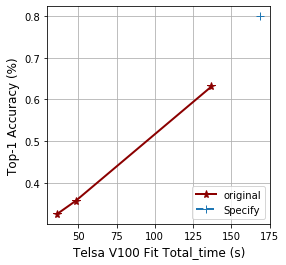

Successfully draw the tradeoff curve!


In [20]:
record.plot('Specify', classifier.results['total_time'], classifier.results['best_reward'])

<div class="alert alert-info">
<h4>Note</h4><p> 此时的搜索空间已经比原来略大，且如果不合理控制搜索空间的范围，则取得相同的accuracy则需要付出巨大成本.</p></div>


In [21]:
classifier.results['search_space']

OrderedDict([('net.choice', Categorical['resnet50_v1b', AutoGluonObject]),
             ('net.1.multiplier', Categorical[0.25, 1.0]),
             ('optimizer.learning_rate', Real: lower=0.0001, upper=0.01),
             ('optimizer.momentum', Real: lower=0.85, upper=0.95),
             ('optimizer.wd', Real: lower=1e-06, upper=0.01)])

In [22]:
classifier.results['best_config']

{'net.1.multiplier.choice': 0,
 'net.choice': 0,
 'optimizer.learning_rate': 0.001,
 'optimizer.momentum': 0.9,
 'optimizer.wd': 0.0001}

根据'best_config', 我们稍微调整一下search space, 多尝试一些trials.

In [23]:
from mxnet import optimizer as optim

@ag.obj(
    multi_precision=True, # False
    learning_rate=ag.space.Real(1e-4, 1e-3, log=True),
    momentum=ag.space.Real(0.88, 0.92),
    wd=ag.space.Real(1e-4, 1e-3, log=True)
)
class NAG(optim.NAG):
    pass

optimizer = NAG()
print(optimizer)

AutoGluonObject -- NAG


Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 3


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.31.37.165/24611/1' processes=1 threads=8, memory=64.28 GB>, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
})



Saving Training Curve in checkpoint/plot_training_curves.png


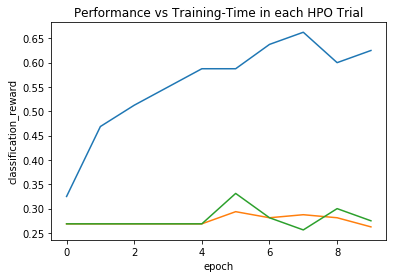

In [24]:
classifier = task.fit(dataset,
                      net=net,
                      num_trials=3,
                      optimizer=optimizer,
                      epochs=10,
                      ngpus_per_trial=1)

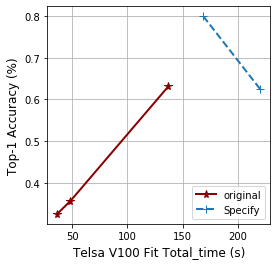

Successfully draw the tradeoff curve!


In [25]:
record.plot('Specify', classifier.results['total_time'], classifier.results['best_reward'])

<kbd>3. 定义搜索方法</kbd> <br />

search_strategy : str
        Which hyperparameter search algorithm to use.
        Options include: 'random' (random search), 'skopt' (SKopt Bayesian
        optimization), 'grid' (grid search), 'hyperband' (Hyperband random),
        'rl' (reinforcement learner).

Bayesian Optimization
:class:`autogluon.searcher.SKoptSearcher`

In [26]:
search_strategy='skopt'
search_options={'base_estimator': 'RF', 'acq_func': 'EI'}

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.31.37.165/24611/1' processes=1 threads=8, memory=64.28 GB>, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
})



Saving Training Curve in checkpoint/plot_training_curves.png


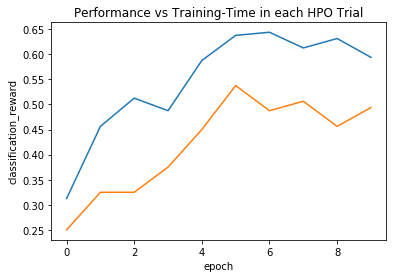

In [27]:
classifier = task.fit(dataset,
                      net=net,
                      optimizer=optimizer,
                      search_strategy=search_strategy, 
                      search_options=search_options,
                      # time_limits=2*60,
                      epochs=10,
                      ngpus_per_trial=1)

classifier.results

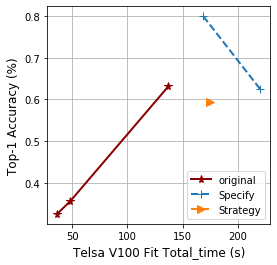

Successfully draw the tradeoff curve!


In [28]:
record.plot('Strategy', classifier.results['total_time'], classifier.results['best_reward'])

<div class="alert alert-info">
<h4>Note</h4><p> 当trials数量较少，看不出不同Strategy明显的差别，当然也和搜索空间有关系.</p></div>

Hyperband
:class:`autogluon.scheduler.HyperbandScheduler`:

grace_period is deprecated, use scheduler_options={'grace_period': ...} instead
Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 16


scheduler: HyperbandScheduler(terminator: HyperbandStopping_Manager(reward_attr: classification_reward, time_attr: epoch, reduction_factor: 3, max_t: 10, brackets: [Bracket: Iter 9.000: None | Iter 3.000: None | Iter 1.000: None])


Saving Training Curve in checkpoint/plot_training_curves.png


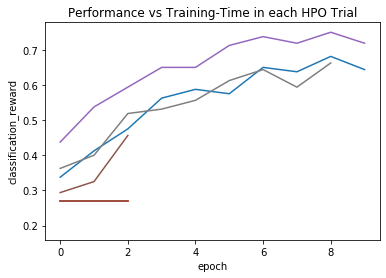

In [29]:
classifier = task.fit(dataset,
                      net=net,
                      optimizer=optimizer,
                      search_strategy='hyperband',
                      epochs=10,
                      num_trials=16,
                      verbose=False,
                      plot_results=True,
                      ngpus_per_trial=1,
                      grace_period=1)



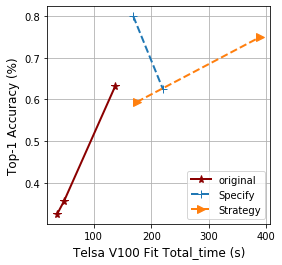

Successfully draw the tradeoff curve!


In [30]:
record.plot('Strategy', classifier.results['total_time'], classifier.results['best_reward'])

<div class="alert alert-info">
<h4>搜索空间以及搜索最优结果</h4><p>``search_space`` && ``best_config`` .</p></div>

In [31]:
for name, range_ in classifier.results['search_space'].items():
    print(name, range_)

net.choice Categorical['resnet50_v1b', AutoGluonObject]
net.1.multiplier Categorical[0.25, 1.0]
optimizer.learning_rate Real: lower=0.0001, upper=0.001
optimizer.momentum Real: lower=0.88, upper=0.92
optimizer.wd Real: lower=0.0001, upper=0.001


In [32]:
classifier.results['best_config']

{'net.1.multiplier.choice': 1,
 'net.choice': 0,
 'optimizer.learning_rate': 0.0006907774553705061,
 'optimizer.momentum': 0.8851832038632612,
 'optimizer.wd': 0.00040518608217580905}

In [33]:
classifier.results['best_reward']

0.75

In [34]:
# print('Top-1 val acc: %.3f' % classifier.results[classifier.results['reward_attr']])
test_acc = classifier.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc)


Top-1 test acc: 0.828


测试集结果直接影响刷榜结果

<kbd>4. Ensemble多个较好的模型 </kbd> <br />

选择'resnet50_v1b'

In [35]:
net = 'resnet50_v1b'

In [36]:
@ag.obj(
    multi_precision=True, # False
    learning_rate=ag.space.Real(0.000690, 0.00690, log=True),
    momentum=ag.space.Real(0.8851, 0.8951),
    wd=ag.space.Real(0.0004051, 0.0004551, log=True)
)
class NAG(optim.NAG):
    pass

optimizer = NAG()
print(optimizer)

AutoGluonObject -- NAG


grace_period is deprecated, use scheduler_options={'grace_period': ...} instead
Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 16


scheduler: HyperbandScheduler(terminator: HyperbandStopping_Manager(reward_attr: classification_reward, time_attr: epoch, reduction_factor: 3, max_t: 10, brackets: [Bracket: Iter 9.000: None | Iter 3.000: None | Iter 1.000: None])


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd974028358>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd974028198>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 33}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd98548e400>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd98548e4e0>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 34}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd974026518>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd98544b3c8>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 35}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd98544b8d0>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd98544b6d8>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 36}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd97404f748>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd97404ff28>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 37}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd985422cf8>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd985422c18>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 38}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd97404f198>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd97404feb8>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 39}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd974026d30>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd9851b7550>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 40}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd985171048>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd985171438>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 41}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd98510c080>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd98510c358>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 42}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd9850ea240>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd9850ea550>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 43}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd9850f14e0>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd9850f1a20>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 44}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd985171ef0>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd97404f518>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 45}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd98510c0b8>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd985072048>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 46}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd97404f438>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd98509bda0>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 47}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd9850ea400>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd9850f10b8>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': False, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 48}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd98510ce48>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd9850722b0>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': True, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 49}


Saving Training Curve in checkpoint/plot_training_curves.png


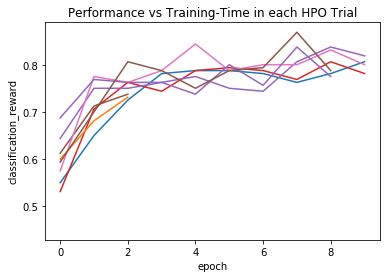

{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd984e45ba8>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd984e45588>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': True, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 50}


{'dataset': <autogluon.task.image_classification.dataset.NativeImageFolderDataset object at 0x7fd97c5667b8>, 'net': 'resnet50_v1b', 'optimizer': <__main__.NAG object at 0x7fd97c5757f0>, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'metric': 'accuracy', 'num_gpus': 1, 'split_ratio': 0.8, 'batch_size': 64, 'input_size': 224, 'epochs': 10, 'final_fit_epochs': 10, 'verbose': True, 'num_workers': 8, 'hybridize': True, 'final_fit': True, 'tricks': Dict{'last_gamma': False, 'use_pretrained': True, 'use_se': False, 'mixup': False, 'mixup_alpha': 0.2, 'mixup_off_epoch': 0, 'label_smoothing': False, 'no_wd': False, 'teacher_name': None, 'temperature': 20.0, 'hard_weight': 0.5, 'batch_norm': False, 'use_gn': False}, 'lr_config': Dict{'lr_mode': 'cosine', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '40,80', 'warmup_lr': 0.0, 'warmup_epochs': 0}, 'task_id': 51}


In [37]:
classifier = task.fit(dataset,
                      net=net,
                      optimizer=optimizer,
                      search_strategy='hyperband',
                      epochs=10,
                      num_trials=16,
                      plot_results=True,
                      ngpus_per_trial=1,
                      grace_period=1,
                      ensemble=3,
                      verbose=True)

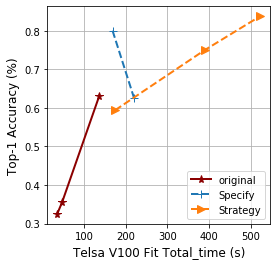

Successfully draw the tradeoff curve!


In [38]:
record.plot('Strategy', classifier.results['total_time'], classifier.results['best_reward'])

In [39]:
# print('Top-1 val acc: %.3f' % classifier.results[classifier.results['reward_attr']])
test_acc = classifier.evaluate(test_dataset)
print('Top-1 test acc: %.3f' % test_acc)


Top-1 test acc: 0.953


## Ensemble Learning

### 数据层面的集成方法
* 测试阶段数据集扩充：多尺度放缩、随机裁剪

### 模型层面的集成方法
单模型集成
* 多层特征融合
* 快照‘snapshot’集成(cyclic cosine annealing)保存多个模型的不同局部最优解

多模型集成
* 不同网络结构
* 同一模型不同初始化
* 同一模型不同训练轮数
* 不同目标函数

集成方法
* 直接平均
* 加权平均
* 投票法(voting)
* 堆叠法(stacking)

最后阶段单独训练3个model，都是best_config下的结果, 已实现最基础的ensemble function.

<div class="alert alert-info">
<h4>Draft</h4>

In [ ]:
!cp ../../AutoGluon-Tutorial-CVPR2020/data/test/BabyShirt/BabyShirt_323.jpg  ./

In [ ]:
!mv BabyShirt_323.jpg data/

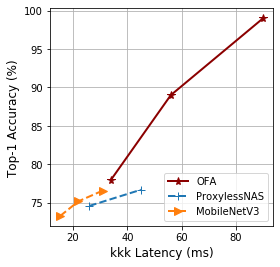

Successfully draw the tradeoff curve!


In [68]:
from matplotlib import pyplot as plt

target_hardware='kkk'

latency_list= [34, 56, 90]
top1s = [78, 89, 99]


plt.figure(figsize=(4,4))
plt.plot(latency_list, top1s, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='OFA')
plt.plot([26, 45], [74.6, 76.7], '--', marker='+', linewidth=2, markersize=8, label='ProxylessNAS')
plt.plot([15.3, 22, 31], [73.3, 75.2, 76.6], '--', marker='>', linewidth=2, markersize=8, label='MobileNetV3')
plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
plt.ylabel('Top-1 Accuracy (%)', size=12)
plt.legend(['OFA', 'ProxylessNAS', 'MobileNetV3'], loc='lower right')
plt.grid(True)
plt.show()
print('Successfully draw the tradeoff curve!')

In [ ]:
record.plot('original', classifier.results['total_time'], classifier.results['best_reward'])

record.plot('++', classifier.results['total_time']+2, classifier.results['best_reward']+1)

record.plot('original', classifier.results['total_time']-1, classifier.results['best_reward']+0.5)

record.plot('++', classifier.results['total_time']+3, classifier.results['best_reward']+4)

record.plot('original', classifier.results['total_time']-0.5, classifier.results['best_reward']-0.5)

record.plot('++', classifier.results['total_time']-4, classifier.results['best_reward']+4)

预测结果

In [ ]:
# image = 'data/test/BabyShirt/BabyShirt_323.jpg'
# image = 'data/BabyShirt_323.jpg'
image = 'womencasualshoes_514.jpg'
image = 'cat.jpg'
ind, prob = classifier.predict(image)
print('The input picture is classified as [%s], with probability %.2f.' %
      (dataset.init().classes[ind.asscalar()], prob.asscalar()))

In [7]:
!pip show graphviz

Name: graphviz
Version: 0.14.1
Summary: Simple Python interface for Graphviz
Home-page: https://github.com/xflr6/graphviz
Author: Sebastian Bank
Author-email: sebastian.bank@uni-leipzig.de
License: MIT
Location: /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages
Requires: 
Required-by: catboost, aws-mxnet-cu101mkl, autogluon


In [35]:
!pip show gluoncv

Name: gluoncv
Version: 0.8.0
Summary: MXNet Gluon CV Toolkit
Home-page: https://github.com/dmlc/gluon-cv
Author: Gluon CV Toolkit Contributors
Author-email: UNKNOWN
License: Apache-2.0
Location: /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages
Requires: scipy, portalocker, tqdm, requests, matplotlib, numpy, Pillow
Required-by: autogluon
